## I/O System Demo for  GeoidIO and SSHIO

### Import GeoidIO from gocean

In [1]:
from matplotlib import pyplot as plt
from gocean.io.geoid import GeoidIO

### Set the data directory for GeoidIO and read the .gdf file

In [2]:
# Set the data directory to GeoidIO
geoid = GeoidIO(data_dir='../../data')

# READ required file
geoid.read('geoid.gdf')

### Let's view the data and header for the geoid

In [7]:
# Required header elements
print('header: \n')
for key in geoid.header.keys():
    print(key, ': ', geoid.header[key])

header: 

lat_max :  22.78
lat_min :  5.18
long_min :  77.77
long_max :  98.67
latitude_parallels :  177
longitude_parallels :  210


In [8]:
# Geoid Data
print('Data: \n', geoid.data)

Data: 
         long    lat      geoid
0      77.77  22.78 -58.897233
1      77.87  22.78 -58.982584
2      77.97  22.78 -59.060798
3      78.07  22.78 -59.127344
4      78.17  22.78 -59.178009
...      ...    ...        ...
37165  98.27   5.18 -20.974614
37166  98.37   5.18 -20.494548
37167  98.47   5.18 -19.996221
37168  98.57   5.18 -19.483223
37169  98.67   5.18 -18.961050

[37170 rows x 3 columns]


### Create a Geoid grid and visualize

In [9]:
# Create geoid grid
geoid.create_geoid_grid()

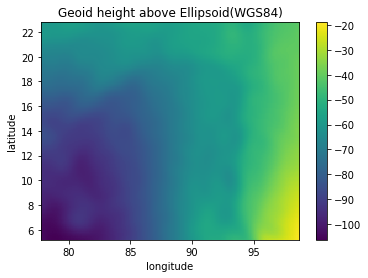

In [18]:
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geoid height above Ellipsoid(WGS84)')

plt.colorbar()
plt.savefig('geoid.png')
plt.show()

### Import SSHIO from gocean

In [13]:
from gocean.io.altimetry import SSHIO

### Set the data directory for jason and saral data

In [14]:
jason = SSHIO('../../data/jason2')

### Read the SSH data and fill the similar grid as geoid

In [15]:
jason.read(geoid.grid)

### Visualize SSH from Jason and SARAL

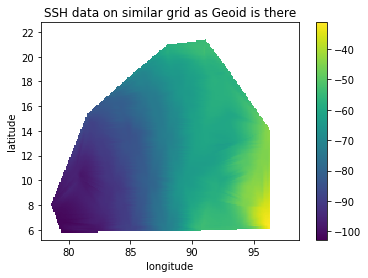

In [17]:
# plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
#                                         geoid.header['long_max'],
#                                         geoid.header['lat_min'],
#                                         geoid.header['lat_max']])
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data on similar grid as Geoid is there')

plt.colorbar()

plt.savefig('ssh.png')
plt.show()

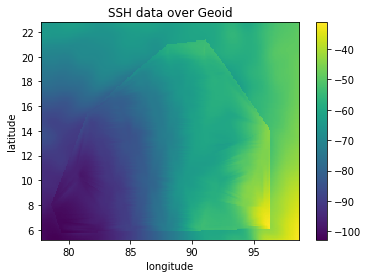

In [19]:
plt.imshow(geoid.grid[:, :, 2], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])
plt.imshow(jason.grid_filled[:, :], extent=[geoid.header['long_min'],
                                        geoid.header['long_max'],
                                        geoid.header['lat_min'],
                                        geoid.header['lat_max']])

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('SSH data over Geoid')

plt.colorbar()

plt.savefig('ssh-geoid.png')
plt.show()


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])